# Financial Complaint Dispute Prediction Model Report
## Introduction
The Consumer Financial Protection Bureau (CFPB) is a U.S. government agency that makes sure financial companies treat their customers fairly. Their website allows customers of financial services to file complaints against financial companies and banks against unfair treatment if these companies are unable to resolve complaints to the customer’s satisfaction.
 
When customers choose to complain to the CFPB, financial companies incur additional costs to resolve such complaints.

On receipt, the CFPB routes complaints to the financial companies, who generally respond to the consumer within 15 days.  Once a response is provided, one of two things can happen:

1.In most cases, consumers accept the response or remediation offered by the financial companies, 
2.In other cases, they choose to dispute the resolution offered by the company.  (flagged in the 'Consumer disputed?' field).  In these situations, the bank has to perform additional investigations, and possibly offer further relief to the customers.  As a result, the cost of dealing with disputes can be high.

The original dataset for this project has over 2 million anonymized recent records, and covers 6000+ financial providers of all varieties available at https://www.consumerfinance.gov/data-research/consumer-complaints/.  The website also provides additional information on the data, including the data dictionary.  

For this project, I am using only the data till 2017, and only for the top 5 banks in the US. 

The cost structure:

1.On average, it costs the banks $100 to resolve, respond to and close a complaint that is not disputed.  

2.On the other hand, it costs banks an extra $500 to resolve a complaint if it has been disputed.

3.Extra diligence: If the banks know in advance which complaints will be disputed, they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  Performing extra diligence costs $90 per complaint, and provides a guarantee that the customer will not dispute the complaint.  But performing the extra diligence is wasted money if the customer would not have disputed the complaint.

In this notebook I am developing a model to predict whether a financial complaint will be disputed by a consumer. This report details my approach, which includes data exploration, model training with XGBoost, evaluation, and cost analysis. 

## Data Exploration and Preprocessing

### 1.EDA
I began by conducting exploratory data analysis (EDA) to understand the fields within our dataset. This preliminary step was crucial in gaining insights into the nature of the complaints and preparing for effective model training.

In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve


In [2]:
# Loading the data and general information
data = pd.read_csv('shared/complaints_25Nov21.csv')

# Fill for missing values
data.fillna('Unknown', inplace=True)
data

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,Unknown,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",Unknown,Unknown,Unknown,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",Unknown,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",Unknown,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,Unknown,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",Unknown,Unknown,Unknown,JPMORGAN CHASE & CO.,VA,22406,Servicemember,Unknown,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",Unknown,Unknown,Unknown,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,Unknown,Unknown,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,Unknown,Unknown,JPMORGAN CHASE & CO.,FL,33133,Unknown,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Unknown,Unknown,Unknown,JPMORGAN CHASE & CO.,NY,10312,Unknown,Unknown,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,Unknown,Unknown,Unknown,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,Unknown,Unknown,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",Unknown,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,Unknown,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


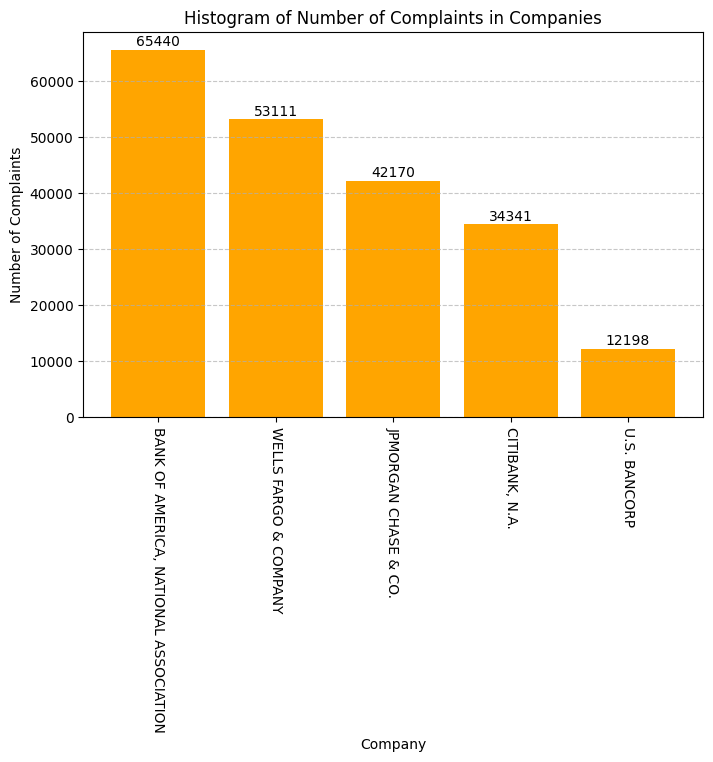

In [3]:
# Count the number of complaints for each bank
complaint_counts = data['Company'].value_counts()

# Create a histogram
plt.figure(figsize=(8, 5))
bars = plt.bar(complaint_counts.index,complaint_counts.values, color="orange")
plt.xlabel("Company")
plt.ylabel("Number of Complaints")
plt.title("Histogram of Number of Complaints in Companies")
plt.xticks(complaint_counts.index)
plt.xticks(rotation=270)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",  # Format the count as an integer
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better placement
        textcoords="offset points",
        ha="center",
    )

plt.show()



### 2.Variable Selection and Encoding
Defining the predictor X and predicted y variables, limiting the predictors to the few specific fields:

In [4]:
# Predictor variables
X = data[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]

# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

# Predicted variable using LabelEncoder for binary classification
le = LabelEncoder()
y = le.fit_transform(data['Consumer disputed?'])


### 3.Train-Test Split
Following the variable selection and encoding, I split the data into training and testing sets with an 80/20 ratio and a random_state for reproducibility:

In [5]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


### 4.Balancing the Dataset
Before proceeding to model training, I checked the balance of our classes:

In [6]:
# Class balance check
print(f"Proportion of disputed complaints in training set: {y_train.mean() * 100:.2f}%")
print(f"Proportion of disputed complaints in Test set: {y_test.mean() * 100:.2f}%")

Proportion of disputed complaints in training set: 21.68%
Proportion of disputed complaints in Test set: 21.59%


If the proportion was found to be less than 30%, I would balance the dataset using random undersampling:

In [7]:
# Balancing the training dataset
undersampler = RandomUnderSampler(random_state=123)
X_train, y_train = undersampler.fit_resample(X_train, y_train)
print(f"Proportion of disputed complaints in training set: {y_train.mean() * 100:.2f}%")

Proportion of disputed complaints in training set: 50.00%


## Model Training
### 5.Initialize and train the mdoel
For model training, I chose the XGBoost classifier due to its performance in handling imbalanced datasets:

In [8]:
# Training the XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

## Model Evaluation
### 6.Classification Report and Confusion Matrix
After training the model, I evaluated its performance on the test set:

              precision    recall  f1-score   support

           0       0.84      0.53      0.65     32504
           1       0.27      0.63      0.38      8948

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.72      0.55      0.59     41452



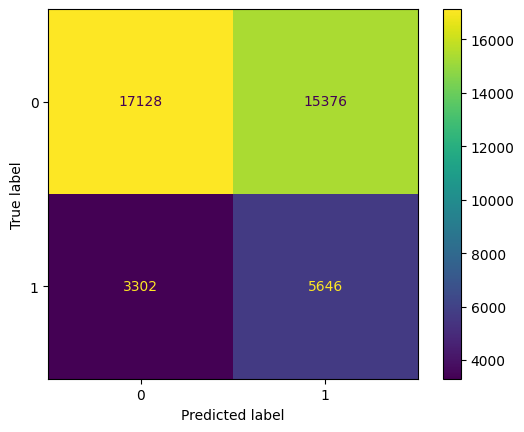

In [9]:
# Making predictions on the test set
y_pred = model_xgb.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

#ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test);
cm=confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();



## Cost Analysis
### 7.Base-Case Cost Calculation
I established a base-case cost without using the model, which would be essential for comparing the model's value:

In [10]:
# Base-case cost calculation
base_case_cost = (y_test == 1).sum() * 600 + (y_test == 0).sum() * 100
print(f"The base-case cost is: ${base_case_cost}")

The base-case cost is: $8619200


### 8.Model-Based Cost Calculation
Utilizing the confusion matrix results, I calculated the total cost implications based on our model's predictions:

In [11]:
# Function to calculate cost from confusion matrix
def calculate_cost(confusion_matrix):
    # Cost when model predicts dispute and actually disputed
    True_NoDispute_Cost = 100 * cm[0, 0]
    
    # Cost when model predicts dispute and no actual dispute
    False_Dispute_Cost = 190 * cm[0,1]
    
    # Cost when model predicts NoDispute and actually disputed
    False_NoDispute_Cost = 600 * cm[1,0]
    
    # Cost when model predicts NoDispute correctly
    True_Dispute_Cost = 190 * cm[1,1]

    total_cost = True_NoDispute_Cost + False_Dispute_Cost + False_NoDispute_Cost + True_Dispute_Cost
    return total_cost

cm = confusion_matrix(y_test, y_pred)
total_cost = calculate_cost(cm)
print(f"The total cost with use of model: ${total_cost}")


The total cost with use of model: $7688180


### 9.Threshold Adjustment for Cost Optimization
Lastly, I iterated over different classification thresholds to minimize the total cost:

In [12]:
# Predict probabilities for the positive class
y_probs = model_xgb.predict_proba(X_test)[:, 1]

# Define a function to calculate cost given a threshold
def calculate_cost(y_true, y_probs, threshold):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate the cost based on the given cost matrix
    cost = tn*100+ fp * 190 + fn * 600 + tp * 190
    return cost

# Step 2: Calculate costs for different thresholds and find the optimal one
thresholds = np.linspace(0, 1, 21) # using fewer thresholds to speed up the processnp.Here,it would only check thresholds at intervals of 0.05.
costs = [calculate_cost(y_test, y_probs, thresh) for thresh in thresholds]

# Create a DataFrame from the thresholds and costs
cost_df = pd.DataFrame({
    'Threshold': thresholds,
    'Cost': costs
})

# Step 3: Find the threshold with the minimum cost
min_cost_row = cost_df.loc[cost_df['Cost'].idxmin()]
optimal_threshold = min_cost_row['Threshold']
minimum_cost = min_cost_row['Cost']

print(f"The minimum cost at this threshold is: ${minimum_cost}")
print(f"The optimal threshold is: {optimal_threshold}")



The minimum cost at this threshold is: $7615730.0
The optimal threshold is: 0.4


## Conclusion
In conclusion, the developed XGBoost classifier model is expected to help in predicting disputed complaints efficiently. The cost analysis will provide a clear picture of the financial implications of utilizing this predictive model as opposed to a base-case scenario. The optimal threshold for classification has been determined to minimize costs further.






**********************************************
## End of Document 
**********************************************